In [20]:
import numpy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST, ImageFolder, DatasetFolder
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image as img

SEED = 1

# This is to ensure matplotlib plots inline and does not try to open a new window.
%matplotlib inline  

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# Show the tensor.
def showTensor(aTensor):
    plt.figure()
    plt.imshow(aTensor.ToPILImage())
    plt.colorbar()
    plt.show()

In [21]:
# Transformation en tenseur :
# Augmentation du dataset (n'augmente pas la taille du dataset, mais il faut augmenter le nombre d'époque 
# par 2 pour chaque transformation)
#
#t = transforms.Compose([transforms.Grayscale(), transforms.RandomRotation(30, resample=False, expand=False, center=None),transforms.ToTensor(),])
t = transforms.Compose([transforms.Grayscale(), transforms.RandomAffine(30, translate=None, scale=None, shear=30),transforms.ToTensor(),])


# Loading datasets
train_dataset = ImageFolder('/home/vbruley/3A/Deep_Learning/Master/PPC2/Train/', transform = t)
test_dataset = ImageFolder('/home/vbruley/3A/Deep_Learning/Master/PPC2/Test/', transform = t)


print("Training data:", train_dataset.classes)
print("\nTest data:", test_dataset)

# Create DataLoader
# Dataloader train
dataloader_args = dict(shuffle=True, batch_size=45,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=45)
train_loader = dataloader.DataLoader(train_dataset, **dataloader_args)

# Dataloader test
dataloader_args = dict(shuffle=True, batch_size=len(test_dataset),num_workers=4, pin_memory=True)
test_loader = dataloader.DataLoader(test_dataset, **dataloader_args)

Training data: ['Paper', 'Rock', 'Scissors']

Test data: Dataset ImageFolder
    Number of datapoints: 69
    Root Location: /home/vbruley/3A/Deep_Learning/Master/PPC2/Test/
    Transforms (if any): Compose(
                             Grayscale(num_output_channels=1)
                             RandomAffine(degrees=(-30, 30), shear=(-30, 30))
                             ToTensor()
                         )
    Target Transforms (if any): None


In [27]:
# One hidden Layer NN
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc = nn.Linear(1024, 1000)
        self.fc2 = nn.Linear(1000, 3)

    def forward(self, x):
        x = x.view((-1, 1024))
        # Activation relu sur fc
        h = F.relu(self.fc(x))
        h = self.fc2(h)
        return F.log_softmax(h, dim=0)    
    
    
model = Model()
if cuda:
    model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [36]:
EPOCHS = 1000
losses = []
acc = []

# Evaluation data iterator
data_iter = iter(test_loader)
evaluate_x, evaluate_y = data_iter.next()
print(evaluate_x.size())
if cuda:
    evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()
    
train_size = len(train_loader.dataset)
batch_size = (train_size / 20) if (cuda) else  (train_size / 20)

# On passe le modèle en training mode
model.train()

for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        data, target = Variable(data), Variable(target)

        if cuda:
            data, target = data.cuda(), target.cuda()
        
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 

        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.cpu().item())
        
        # Backpropagation
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                train_size,
                100. * batch_idx / batch_size, 
                loss.cpu().item()), 
                end='')
            

    # display final evaluation for this epoch
    # On passe le modèle en test mode
    model.eval()

    # Appel de la fonction forward
    output = model(evaluate_x)
    
    # Vecteur de prédiction des données de test
    pred = output.data.max(1)[1]
    
    
    # Test d'égalité entre données de test et prédiction
    d = pred.eq(evaluate_y.data).cpu()
    accuracy = d.sum().item()/d.size()[0]
    acc.append(accuracy)
    
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        train_size, 
        train_size,
        100. * batch_idx / batch_size, 
        loss.cpu().item(),
        accuracy*100,
        end=''))

torch.Size([69, 1, 32, 32])
 Train Epoch: 1/1000 [133/133 (30%)]	Loss: 0.494031	 Test Accuracy: 47.8261%
 Train Epoch: 2/1000 [133/133 (30%)]	Loss: 0.400631	 Test Accuracy: 44.9275%
 Train Epoch: 3/1000 [133/133 (30%)]	Loss: 0.625765	 Test Accuracy: 46.3768%
 Train Epoch: 4/1000 [133/133 (30%)]	Loss: 0.501233	 Test Accuracy: 43.4783%
 Train Epoch: 5/1000 [133/133 (30%)]	Loss: 0.496887	 Test Accuracy: 44.9275%
 Train Epoch: 6/1000 [133/133 (30%)]	Loss: 0.352149	 Test Accuracy: 43.4783%
 Train Epoch: 7/1000 [133/133 (30%)]	Loss: 0.465806	 Test Accuracy: 44.9275%
 Train Epoch: 8/1000 [133/133 (30%)]	Loss: 0.531551	 Test Accuracy: 44.9275%
 Train Epoch: 9/1000 [133/133 (30%)]	Loss: 0.460833	 Test Accuracy: 37.6812%
 Train Epoch: 10/1000 [133/133 (30%)]	Loss: 0.513366	 Test Accuracy: 36.2319%
 Train Epoch: 11/1000 [133/133 (30%)]	Loss: 0.359080	 Test Accuracy: 43.4783%
 Train Epoch: 12/1000 [133/133 (30%)]	Loss: 0.408578	 Test Accuracy: 43.4783%
 Train Epoch: 13/1000 [133/133 (30%)]	Loss: 0

 Train Epoch: 107/1000 [133/133 (30%)]	Loss: 0.418336	 Test Accuracy: 43.4783%
 Train Epoch: 108/1000 [133/133 (30%)]	Loss: 0.385554	 Test Accuracy: 44.9275%
 Train Epoch: 109/1000 [133/133 (30%)]	Loss: 0.497479	 Test Accuracy: 37.6812%
 Train Epoch: 110/1000 [133/133 (30%)]	Loss: 0.368259	 Test Accuracy: 40.5797%
 Train Epoch: 111/1000 [133/133 (30%)]	Loss: 0.383912	 Test Accuracy: 46.3768%
 Train Epoch: 112/1000 [133/133 (30%)]	Loss: 0.325487	 Test Accuracy: 50.7246%
 Train Epoch: 113/1000 [133/133 (30%)]	Loss: 0.609836	 Test Accuracy: 49.2754%
 Train Epoch: 114/1000 [133/133 (30%)]	Loss: 0.395481	 Test Accuracy: 44.9275%
 Train Epoch: 115/1000 [133/133 (30%)]	Loss: 0.483629	 Test Accuracy: 44.9275%
 Train Epoch: 116/1000 [133/133 (30%)]	Loss: 0.365488	 Test Accuracy: 39.1304%
 Train Epoch: 117/1000 [133/133 (30%)]	Loss: 0.351434	 Test Accuracy: 44.9275%
 Train Epoch: 118/1000 [133/133 (30%)]	Loss: 0.374711	 Test Accuracy: 46.3768%
 Train Epoch: 119/1000 [133/133 (30%)]	Loss: 0.40179

 Train Epoch: 211/1000 [133/133 (30%)]	Loss: 0.360012	 Test Accuracy: 52.1739%
 Train Epoch: 212/1000 [133/133 (30%)]	Loss: 0.314358	 Test Accuracy: 46.3768%
 Train Epoch: 213/1000 [133/133 (30%)]	Loss: 0.281082	 Test Accuracy: 44.9275%
 Train Epoch: 214/1000 [133/133 (30%)]	Loss: 0.202081	 Test Accuracy: 42.0290%
 Train Epoch: 215/1000 [133/133 (30%)]	Loss: 0.269773	 Test Accuracy: 44.9275%
 Train Epoch: 216/1000 [133/133 (30%)]	Loss: 0.285975	 Test Accuracy: 46.3768%
 Train Epoch: 217/1000 [133/133 (30%)]	Loss: 0.326956	 Test Accuracy: 42.0290%
 Train Epoch: 218/1000 [133/133 (30%)]	Loss: 0.362189	 Test Accuracy: 44.9275%
 Train Epoch: 219/1000 [133/133 (30%)]	Loss: 0.300474	 Test Accuracy: 47.8261%
 Train Epoch: 220/1000 [133/133 (30%)]	Loss: 0.185226	 Test Accuracy: 46.3768%
 Train Epoch: 221/1000 [133/133 (30%)]	Loss: 0.294371	 Test Accuracy: 46.3768%
 Train Epoch: 222/1000 [133/133 (30%)]	Loss: 0.354250	 Test Accuracy: 44.9275%
 Train Epoch: 223/1000 [133/133 (30%)]	Loss: 0.27490

 Train Epoch: 315/1000 [133/133 (30%)]	Loss: 0.192077	 Test Accuracy: 40.5797%
 Train Epoch: 316/1000 [133/133 (30%)]	Loss: 0.310754	 Test Accuracy: 46.3768%
 Train Epoch: 317/1000 [133/133 (30%)]	Loss: 0.255407	 Test Accuracy: 49.2754%
 Train Epoch: 318/1000 [133/133 (30%)]	Loss: 0.193080	 Test Accuracy: 46.3768%
 Train Epoch: 319/1000 [133/133 (30%)]	Loss: 0.370443	 Test Accuracy: 46.3768%
 Train Epoch: 320/1000 [133/133 (30%)]	Loss: 0.287364	 Test Accuracy: 42.0290%
 Train Epoch: 321/1000 [133/133 (30%)]	Loss: 0.291274	 Test Accuracy: 44.9275%
 Train Epoch: 322/1000 [133/133 (30%)]	Loss: 0.505737	 Test Accuracy: 43.4783%
 Train Epoch: 323/1000 [133/133 (30%)]	Loss: 0.266562	 Test Accuracy: 49.2754%
 Train Epoch: 324/1000 [133/133 (30%)]	Loss: 0.228667	 Test Accuracy: 50.7246%
 Train Epoch: 325/1000 [133/133 (30%)]	Loss: 0.307817	 Test Accuracy: 46.3768%
 Train Epoch: 326/1000 [133/133 (30%)]	Loss: 0.550921	 Test Accuracy: 40.5797%
 Train Epoch: 327/1000 [133/133 (30%)]	Loss: 0.48847

 Train Epoch: 420/1000 [133/133 (30%)]	Loss: 0.366243	 Test Accuracy: 46.3768%
 Train Epoch: 421/1000 [133/133 (30%)]	Loss: 0.361332	 Test Accuracy: 43.4783%
 Train Epoch: 422/1000 [133/133 (30%)]	Loss: 0.194059	 Test Accuracy: 43.4783%
 Train Epoch: 423/1000 [133/133 (30%)]	Loss: 0.227147	 Test Accuracy: 37.6812%
 Train Epoch: 424/1000 [133/133 (30%)]	Loss: 0.329849	 Test Accuracy: 40.5797%
 Train Epoch: 425/1000 [133/133 (30%)]	Loss: 0.275053	 Test Accuracy: 44.9275%
 Train Epoch: 426/1000 [133/133 (30%)]	Loss: 0.228370	 Test Accuracy: 43.4783%
 Train Epoch: 427/1000 [133/133 (30%)]	Loss: 0.342878	 Test Accuracy: 39.1304%
 Train Epoch: 428/1000 [133/133 (30%)]	Loss: 0.249718	 Test Accuracy: 40.5797%
 Train Epoch: 429/1000 [133/133 (30%)]	Loss: 0.190413	 Test Accuracy: 42.0290%
 Train Epoch: 430/1000 [133/133 (30%)]	Loss: 0.325247	 Test Accuracy: 39.1304%
 Train Epoch: 431/1000 [133/133 (30%)]	Loss: 0.269200	 Test Accuracy: 37.6812%
 Train Epoch: 432/1000 [133/133 (30%)]	Loss: 0.28449

 Train Epoch: 524/1000 [133/133 (30%)]	Loss: 0.227799	 Test Accuracy: 43.4783%
 Train Epoch: 525/1000 [133/133 (30%)]	Loss: 0.256144	 Test Accuracy: 43.4783%
 Train Epoch: 526/1000 [133/133 (30%)]	Loss: 0.182733	 Test Accuracy: 46.3768%
 Train Epoch: 527/1000 [133/133 (30%)]	Loss: 0.245220	 Test Accuracy: 44.9275%
 Train Epoch: 528/1000 [133/133 (30%)]	Loss: 0.245726	 Test Accuracy: 46.3768%
 Train Epoch: 529/1000 [133/133 (30%)]	Loss: 0.239371	 Test Accuracy: 46.3768%
 Train Epoch: 530/1000 [133/133 (30%)]	Loss: 0.275805	 Test Accuracy: 50.7246%
 Train Epoch: 531/1000 [133/133 (30%)]	Loss: 0.177436	 Test Accuracy: 47.8261%
 Train Epoch: 532/1000 [133/133 (30%)]	Loss: 0.240695	 Test Accuracy: 47.8261%
 Train Epoch: 533/1000 [133/133 (30%)]	Loss: 0.185836	 Test Accuracy: 46.3768%
 Train Epoch: 534/1000 [133/133 (30%)]	Loss: 0.220312	 Test Accuracy: 43.4783%
 Train Epoch: 535/1000 [133/133 (30%)]	Loss: 0.298912	 Test Accuracy: 47.8261%
 Train Epoch: 536/1000 [133/133 (30%)]	Loss: 0.31205

 Train Epoch: 629/1000 [133/133 (30%)]	Loss: 0.445421	 Test Accuracy: 46.3768%
 Train Epoch: 630/1000 [133/133 (30%)]	Loss: 0.246439	 Test Accuracy: 44.9275%
 Train Epoch: 631/1000 [133/133 (30%)]	Loss: 0.319341	 Test Accuracy: 37.6812%
 Train Epoch: 632/1000 [133/133 (30%)]	Loss: 0.330811	 Test Accuracy: 37.6812%
 Train Epoch: 633/1000 [133/133 (30%)]	Loss: 0.211819	 Test Accuracy: 43.4783%
 Train Epoch: 634/1000 [133/133 (30%)]	Loss: 0.271887	 Test Accuracy: 46.3768%
 Train Epoch: 635/1000 [133/133 (30%)]	Loss: 0.252210	 Test Accuracy: 47.8261%
 Train Epoch: 636/1000 [133/133 (30%)]	Loss: 0.198676	 Test Accuracy: 40.5797%
 Train Epoch: 637/1000 [133/133 (30%)]	Loss: 0.220309	 Test Accuracy: 40.5797%
 Train Epoch: 638/1000 [133/133 (30%)]	Loss: 0.305844	 Test Accuracy: 40.5797%
 Train Epoch: 639/1000 [133/133 (30%)]	Loss: 0.276086	 Test Accuracy: 47.8261%
 Train Epoch: 640/1000 [133/133 (30%)]	Loss: 0.316941	 Test Accuracy: 47.8261%
 Train Epoch: 641/1000 [133/133 (30%)]	Loss: 0.16177

 Train Epoch: 734/1000 [133/133 (30%)]	Loss: 0.165061	 Test Accuracy: 39.1304%
 Train Epoch: 735/1000 [133/133 (30%)]	Loss: 0.304141	 Test Accuracy: 39.1304%
 Train Epoch: 736/1000 [133/133 (30%)]	Loss: 0.168871	 Test Accuracy: 39.1304%
 Train Epoch: 737/1000 [133/133 (30%)]	Loss: 0.175262	 Test Accuracy: 40.5797%
 Train Epoch: 738/1000 [133/133 (30%)]	Loss: 0.152723	 Test Accuracy: 43.4783%
 Train Epoch: 739/1000 [133/133 (30%)]	Loss: 0.210781	 Test Accuracy: 43.4783%
 Train Epoch: 740/1000 [133/133 (30%)]	Loss: 0.193741	 Test Accuracy: 40.5797%
 Train Epoch: 741/1000 [133/133 (30%)]	Loss: 0.218743	 Test Accuracy: 44.9275%
 Train Epoch: 742/1000 [133/133 (30%)]	Loss: 0.181447	 Test Accuracy: 43.4783%
 Train Epoch: 743/1000 [133/133 (30%)]	Loss: 0.159141	 Test Accuracy: 46.3768%
 Train Epoch: 744/1000 [133/133 (30%)]	Loss: 0.207639	 Test Accuracy: 43.4783%
 Train Epoch: 745/1000 [133/133 (30%)]	Loss: 0.170782	 Test Accuracy: 39.1304%
 Train Epoch: 746/1000 [133/133 (30%)]	Loss: 0.19984

 Train Epoch: 839/1000 [133/133 (30%)]	Loss: 0.339198	 Test Accuracy: 40.5797%
 Train Epoch: 840/1000 [133/133 (30%)]	Loss: 0.096218	 Test Accuracy: 40.5797%
 Train Epoch: 841/1000 [133/133 (30%)]	Loss: 0.256998	 Test Accuracy: 40.5797%
 Train Epoch: 842/1000 [133/133 (30%)]	Loss: 0.181252	 Test Accuracy: 44.9275%
 Train Epoch: 843/1000 [133/133 (30%)]	Loss: 0.169825	 Test Accuracy: 47.8261%
 Train Epoch: 844/1000 [133/133 (30%)]	Loss: 0.220659	 Test Accuracy: 44.9275%
 Train Epoch: 845/1000 [133/133 (30%)]	Loss: 0.105207	 Test Accuracy: 40.5797%
 Train Epoch: 846/1000 [133/133 (30%)]	Loss: 0.213031	 Test Accuracy: 39.1304%
 Train Epoch: 847/1000 [133/133 (30%)]	Loss: 0.187881	 Test Accuracy: 37.6812%
 Train Epoch: 848/1000 [133/133 (30%)]	Loss: 0.290909	 Test Accuracy: 40.5797%
 Train Epoch: 849/1000 [133/133 (30%)]	Loss: 0.141574	 Test Accuracy: 40.5797%
 Train Epoch: 850/1000 [133/133 (30%)]	Loss: 0.136018	 Test Accuracy: 37.6812%
 Train Epoch: 851/1000 [133/133 (30%)]	Loss: 0.20648

 Train Epoch: 944/1000 [133/133 (30%)]	Loss: 0.260975	 Test Accuracy: 39.1304%
 Train Epoch: 945/1000 [133/133 (30%)]	Loss: 0.113927	 Test Accuracy: 37.6812%
 Train Epoch: 946/1000 [133/133 (30%)]	Loss: 0.119895	 Test Accuracy: 37.6812%
 Train Epoch: 947/1000 [133/133 (30%)]	Loss: 0.157129	 Test Accuracy: 37.6812%
 Train Epoch: 948/1000 [133/133 (30%)]	Loss: 0.169477	 Test Accuracy: 36.2319%
 Train Epoch: 949/1000 [133/133 (30%)]	Loss: 0.094837	 Test Accuracy: 40.5797%
 Train Epoch: 950/1000 [133/133 (30%)]	Loss: 0.241762	 Test Accuracy: 43.4783%
 Train Epoch: 951/1000 [133/133 (30%)]	Loss: 0.204074	 Test Accuracy: 39.1304%
 Train Epoch: 952/1000 [133/133 (30%)]	Loss: 0.212901	 Test Accuracy: 39.1304%
 Train Epoch: 953/1000 [133/133 (30%)]	Loss: 0.144509	 Test Accuracy: 44.9275%
 Train Epoch: 954/1000 [133/133 (30%)]	Loss: 0.113060	 Test Accuracy: 46.3768%
 Train Epoch: 955/1000 [133/133 (30%)]	Loss: 0.201344	 Test Accuracy: 44.9275%
 Train Epoch: 956/1000 [133/133 (30%)]	Loss: 0.09084

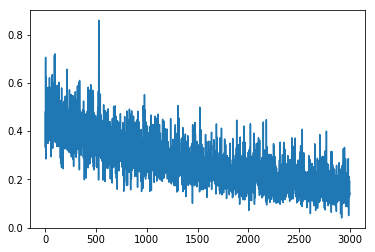

In [37]:
# Evolution des résultats de la fonction "loss" :
plt.plot(losses)

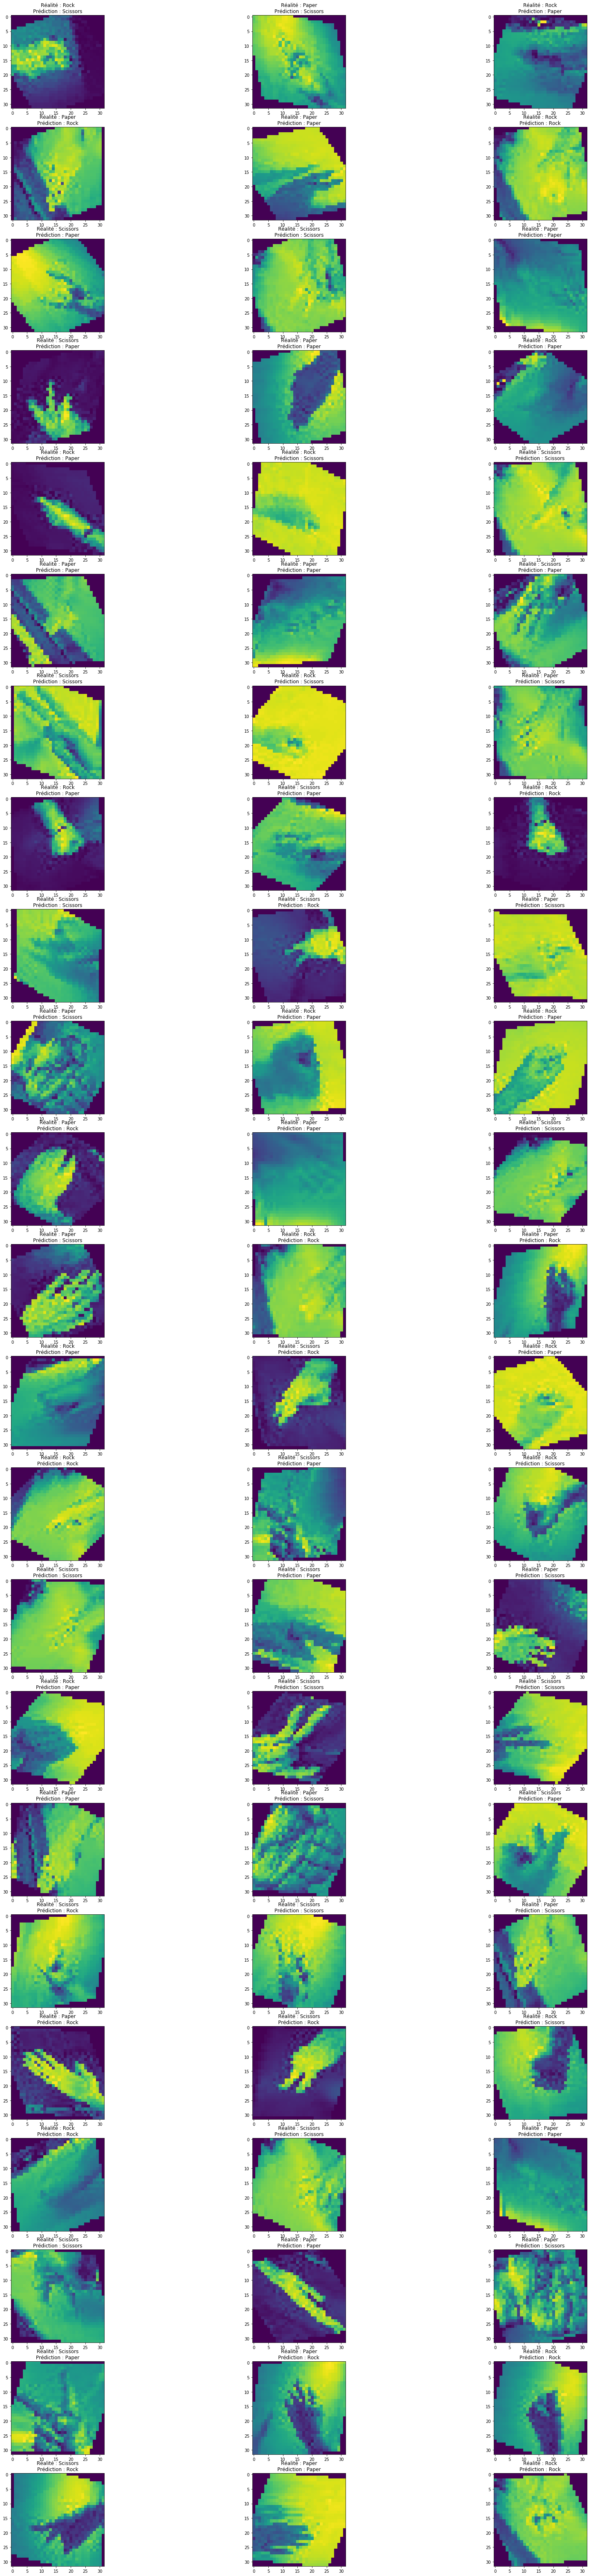

In [14]:
# define the figure size and grid layout properties

cols = 3
s = evaluate_x.size()[0]
ligs = (s//cols) +1

evalua = np.asarray(evaluate_y)
prediction = np.asarray(pred)
fig = plt.figure(figsize=(30,120))

for i in range(69):
    fig.add_subplot(24,3,i+1)
    plt.imshow(evaluate_x[i].squeeze(0))
    plt.title('Réalité : ' + train_dataset.classes[evalua[i]] + '\n' + 'Prédiction : ' + train_dataset.classes[prediction[i]])
    